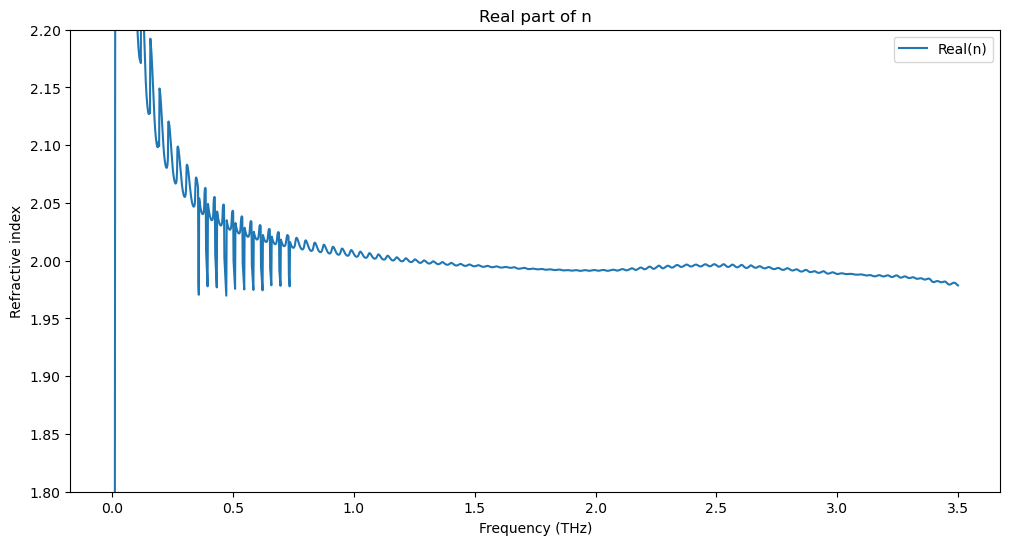

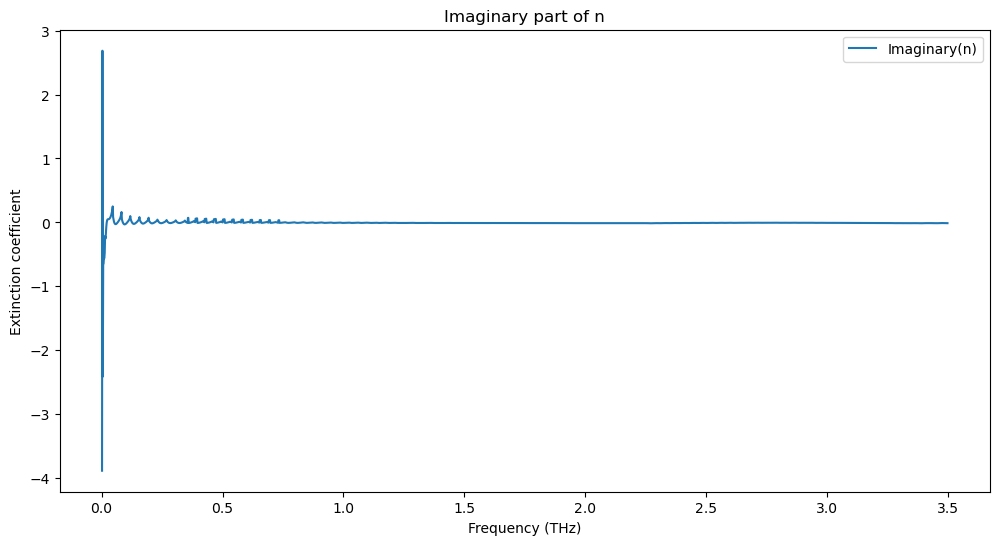

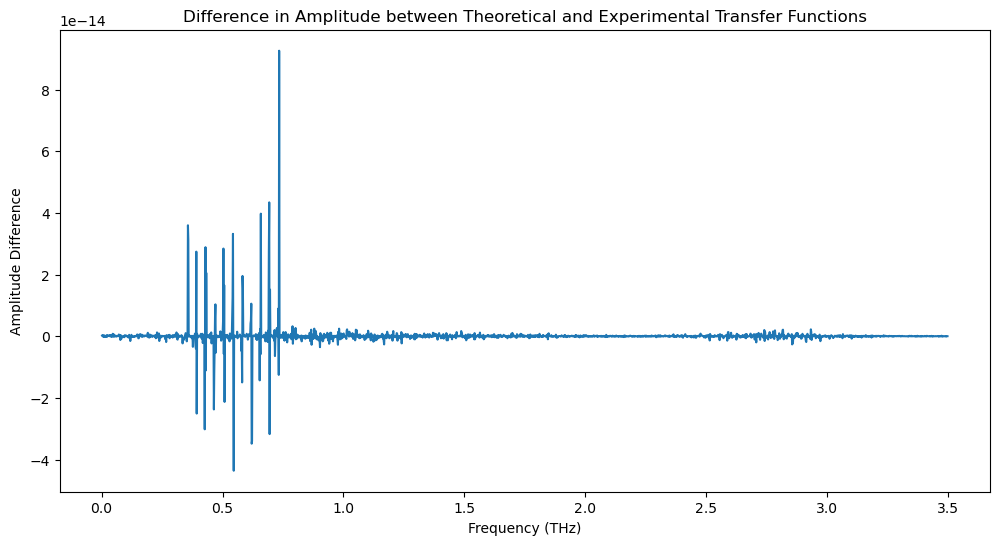

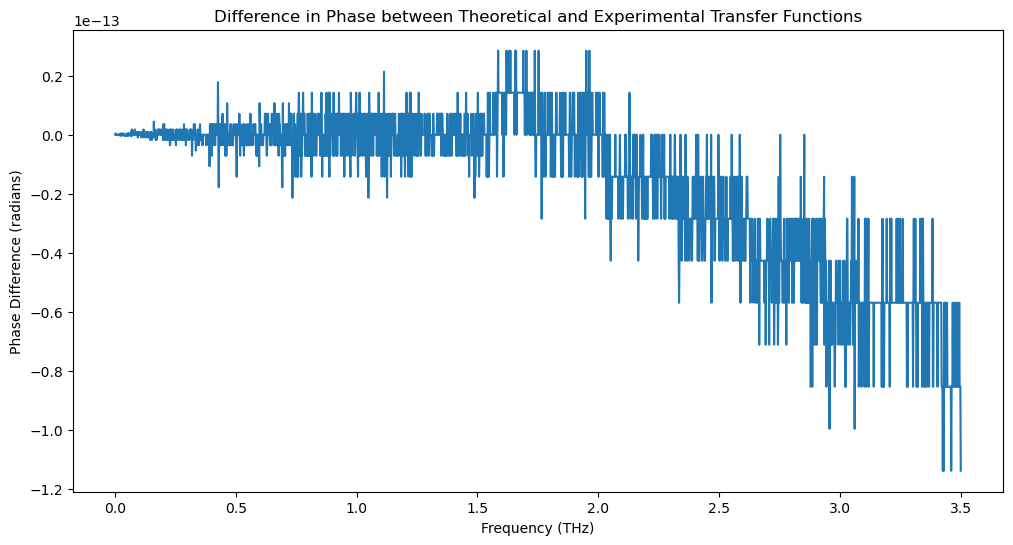

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

# LOAD DATA
datar = np.loadtxt("AmpTimeRef.txt", dtype=float)
datas = np.loadtxt("AmpTimeSample.txt", dtype=float)
ts = datas[:, 0]
tr = datar[:, 0]
sr = datar[:, 1]
ss = datas[:, 1]

# INTERPOLATION
startt = 0
endt = 4.6116 * 10**-11
dt = min(np.mean(np.diff(ts)), np.mean(np.diff(tr)))
t = np.arange(startt, endt + dt, dt)

sr = np.interp(t, tr, sr, left=0, right=0)
ss = np.interp(t, ts, ss, left=0, right=0)

# FFT
fftr = np.fft.fft(sr, 32768)
ffts = np.fft.fft(ss, 32768)
freq = np.fft.fftfreq(32768, dt)

# MASK
mask = (freq > 0) & (freq < 3.5 * 10**12)
fftr = fftr[mask]
ffts = ffts[mask]
freq = freq[mask]

# TRANSFER FUNCTION
tf = ffts / fftr
phase_unwrapped = np.unwrap(np.angle(tf))
phase_unwrapped -= phase_unwrapped[0]-0.5*np.pi
L=2.01e-3
c=3e8
# DEFINE FUNCTIONS
def F(n, f, lnH_exp):
    lnH_th = (np.log((4 * n) / ((1 + n) ** 2)) 
              - 1j * L * (2 * np.pi * f) * (n - 1) / (c)
              + np.log(1 + ((n - 1) / (n + 1)) ** 2 * np.exp((-4 * 1j * n * np.pi * f * L) / c)))
    return lnH_th - lnH_exp

def G(n, f):
    x = 1 / n - 2 / (1 + n) - 1j * L * (2 * np.pi * f) / c
    y = 2 * ((n - 1) / (n + 1)) ** 2 * np.exp((-4 * 1j * n * np.pi * f * L) / c)
    s=1 + ((n - 1) / (n + 1)) ** 2 * np.exp((-4 * 1j * n * np.pi * f * L) / c)
    z = 1 / (n - 1) - 1 / (n + 1) - 1j * L * (2 * np.pi * f) / (c)
    return x + y * z/s

def n_r(f, lnH_exp, n_0, iterations=50, tolerance=1e-12):
    n = n_0
    for _ in range(iterations):
        F_ = F(n, f, lnH_exp)
        G_ = G(n, f)
        delta_n = F_ / G_
        n = n - delta_n
        if abs(F_/G_) < tolerance:
            break
    return n

# INITIAL GUESS & COMPUTATION
n_0 = 1.98 + 0.05j
n_ = []

for i, f in enumerate(freq):
    lnH_exp = np.log(np.abs(tf[i])) + 1j * phase_unwrapped[i] 
    n = n_r(f, lnH_exp, n_0) 
    n_.append(n)

n_ = np.array(n_)

# COMPUTE THEORETICAL TRANSFER FUNCTION
H_th = np.exp(np.log((4 * n_) / ((1 + n_) ** 2)) 
              - 1j * L * (2 * np.pi * freq) * (n_ - 1) / (c)
              + np.log(1 + ((n_ - 1) / (n_ + 1)) ** 2 * np.exp((-4 * 1j * n_ * np.pi * freq * L) / c)))

# DIFFERENCES IN TRANSFER FUNCTIONS
amp_diff = np.abs(H_th) - np.abs(tf)
phase_diff = np.unwrap(np.angle(H_th)) - phase_unwrapped

# SAVE TO FILES
np.savetxt("n_1.txt", np.column_stack((freq, np.real(n_), np.imag(n_))), header="Frequency(Hz) Real(n) Imag(n)")
np.savetxt("amp_diff_1.txt", np.column_stack((freq, amp_diff)), header="Frequency(Hz) Amplitude Difference")
np.savetxt("phase_diff_1.txt", np.column_stack((freq, phase_diff)), header="Frequency(Hz) Phase Difference")

# PLOT REAL OF COMPLEX REFRACTIVE INDEX
plt.figure(figsize=(12, 6))
plt.plot(freq * 10**-12, np.real(n_), label="Real(n)")
plt.title("Real part of n")
plt.xlabel("Frequency (THz)")
plt.ylabel("Refractive index")
#plt.xlim(0,3)
plt.ylim(1.8,2.2)
plt.legend()

# PLOT IMAGINARY OF COMPLEX REFRACTIVE INDEX
plt.figure(figsize=(12, 6))
plt.plot(freq * 10**-12, np.imag(n_), label="Imaginary(n)")
plt.title("Imaginary part of n")
plt.ylabel("Extinction coefficient")
plt.xlabel("Frequency (THz)")
plt.legend()

# PLOT AMPLITUDE DIFFERENCE OF TRANSFER FUNCTIONS
plt.figure(figsize=(12, 6))
plt.plot(freq * 10**-12, amp_diff)
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude Difference")
plt.title("Difference in Amplitude between Theoretical and Experimental Transfer Functions")

# PLOT PHASE DIFFERENCE OF TRANSFER FUNCTIONS
plt.figure(figsize=(12, 6))
plt.plot(freq * 10**-12, phase_diff)
plt.xlabel("Frequency (THz)")
plt.ylabel("Phase Difference (radians)")
plt.title("Difference in Phase between Theoretical and Experimental Transfer Functions")
plt.show()
